#### Wavenet Workbook

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for figures
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(f"Lenth: {len(words)} | Data Sample: {words[:4]}")

Lenth: 32033 | Data Sample: ['emma', 'olivia', 'ava', 'isabella']


In [3]:
# Build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos.keys())

In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:

# Build dataset
BLOCK_SIZE = 8 
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # %80
Xdev, Ydev = build_dataset(words[n1:n2]) # %10
Xte, Yte = build_dataset(words[n2:]) # %10

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])
    # ...

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [7]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# ------------------------------------------------------------------------------------ 
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a runnning 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # normalize to unit variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
# ------------------------------------------------------------------------------------ 

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# ------------------------------------------------------------------------------------ 
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
# ------------------------------------------------------------------------------------ 
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n) 
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
# ------------------------------------------------------------------------------------ 
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42)

In [13]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
# with torch.no_grad():
    # layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [14]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 10,  1, 11, 15,  4,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  2,  5, 14, 21,  5, 12],
        [ 0,  0,  0,  3,  8,  1, 14, 14]])

In [15]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [16]:

# ----------------------- Set Vars ----------------------- #
max_steps = 200_000
batch_size = 32 
lossi = []

# ----------------------- Train ----------------------- #
for i in range(max_steps):
    # Construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01  # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Stats
    if i % 10000 == 0: # print every so often
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.5489
  10000/ 200000: 2.1344
  20000/ 200000: 1.9490
  30000/ 200000: 2.0645
  40000/ 200000: 1.8253
  50000/ 200000: 1.9669
  60000/ 200000: 1.8448
  70000/ 200000: 1.5295
  80000/ 200000: 2.4376
  90000/ 200000: 1.6904
 100000/ 200000: 1.9519
 110000/ 200000: 2.0058
 120000/ 200000: 1.8671
 130000/ 200000: 1.9862
 140000/ 200000: 2.2823
 150000/ 200000: 1.9531
 160000/ 200000: 2.2379
 170000/ 200000: 2.1987
 180000/ 200000: 1.8113
 190000/ 200000: 1.8515


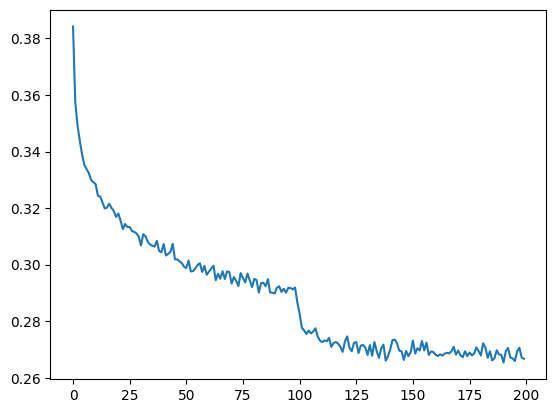

In [17]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [18]:
for layer in model.layers:
    layer.training = False

In [19]:

@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.113985776901245
val 2.348491907119751


In [20]:
for _ in range(10):
    out = []
    context = [0] * BLOCK_SIZE # initialize with all...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from distibution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

miguell.
evegionna.
ashvihar.
annon.
tedrianny.
guvitabith.
remmalo.
eilivuan.
estephaelynn.
imerika.
